# DataJoint Elements for [Facemap](https://github.com/MouseLand/facemap) Pose Estimation

#### Open-source data pipeline for orofacial movement tracking and pose estimation of distinct facial keypoints.

Welcome to the tutorial for the DataJoint Element for pose estimation of distinct
keypoints on the mouse face. This
tutorial aims to provide a comprehensive understanding of the open-source data pipeline
created using `element-facemap`'s pose estimation inference module.

This package is designed to seamlessly process, ingest, and track facemap's pose
estimation data, along with its associated video recording and model metadata. By the end of this
tutorial you will have a clear grasp on setting up and integrating `element-facemap`
into your specific research projects and lab. 

![flowchart](../images/flowchart.svg)

### Prerequisites

Please see the [datajoint tutorials GitHub
repository](https://github.com/datajoint/datajoint-tutorials/tree/main) before
proceeding.

A basic understanding of the following DataJoint concepts will be beneficial to your
understanding of this tutorial: 
1. The `Imported` and `Computed` tables types in `datajoint-python`.
2. The functionality of the `.populate()` method. 

#### **Tutorial Overview**

+ Setup
+ *Activate* the DataJoint pipeline.
+ *Insert* subject and session metadata.
+ *Populate* video recording and models metadata.
+ Run the pose estimation task.
+ Visualize the results.

### **Setup**

This tutorial examines video data for facemap analysis. The goal is to store, track and
manage sessions of facial key points data, including determining coordinates of facial body
parts and trajectory visualizations.

The results of this Element can be combined with **other modalities** to create a complete,
customizable data pipeline for your specific lab or study. For instance, you can combine
`element-facemap` with `element-calcium-imaging` and `element-array-ephys` to relate orofacial
behavior to neural activity.

Let's start this tutorial by importing the packages necessary to run the notebook.

In [1]:
import datajoint as dj
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from matplotlib import cm

If the tutorial is run in Codespaces, a private, local database server is created and
made available for you. This is where we will insert and store our processed results.
Let's connect to the database server.

In [2]:
dj.conn()

[2024-03-19 23:07:50,332][INFO]: Connecting root@fakeservices.datajoint.io:3306
[2024-03-19 23:07:50,340][INFO]: Connected root@fakeservices.datajoint.io:3306


DataJoint connection (connected) root@fakeservices.datajoint.io:3306

### **Activate the DataJoint Pipeline**

This tutorial activates the `facemap_inference.py` module from `element-facemap`, along
with upstream dependencies from `element-animal` and `element-session`. Please refer to the
[`tutorial_pipeline.py`](./tutorial_pipeline.py) for the source code.

In [3]:
from tutorial_pipeline import (
    subject,
    session,
    facial_behavior_estimation as fbe,
    facemap_inference,
    Device,
)

[2024-03-19 23:07:50,499][WARNING]: lab.Project and related tables will be removed in a future version of Element Lab. Please use the project schema.


We can represent the `fbe` (SVD-based facemap) and `facemap_inference` (pose-estimation
on keypoints) schemas and their upstream dependencies, `session` and `subject` schemas
as a diagram.

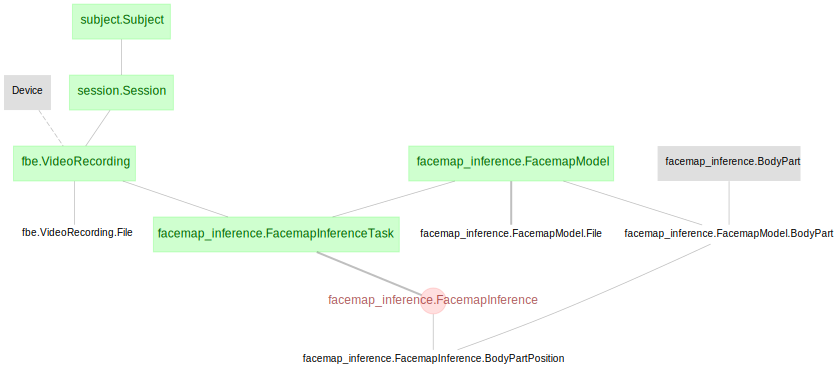

In [4]:
(
    dj.Diagram(subject.Subject)
    + dj.Diagram(session.Session)
    + dj.Diagram(Device)
    + dj.Diagram(fbe.VideoRecording)
    + dj.Diagram(fbe.VideoRecording.File)
    + dj.Diagram(facemap_inference)
)

As evident from the diagram, this data pipeline encompasses tables associated with
model and video file data, task generation and results of model inference. A few tables, such as `subject.Subject` or `session.Session`,
while important for a complete pipeline, fall outside the scope of the `element-facemap`
tutorial, and will therefore, not be explored extensively here. The primary focus of
this tutorial will be on the `facemap_inference` schema.

### **Insert subject, session, and video metadata**

Let's start with the first table in the schema diagram (i.e. `subject.Subject` table).

To know what data to insert into the table, we can view its dependencies and attributes using the `.describe()` and `.heading` methods.

In [5]:
subject.Subject()

subject,subject_nickname,sex,subject_birth_date,subject_description


In [6]:
print(subject.Subject.describe())

subject              : varchar(8)                   
---
subject_nickname=""  : varchar(64)                  
sex                  : enum('M','F','U')            
subject_birth_date   : date                         
subject_description="" : varchar(1024)                



In [7]:
subject.Subject.heading

# 
subject              : varchar(8)                   # 
---
subject_nickname=""  : varchar(64)                  # 
sex                  : enum('M','F','U')            # 
subject_birth_date   : date                         # 
subject_description="" : varchar(1024)                # 

The cells above show all attributes of the subject table.
We will insert data into the
`subject.Subject` table. 

In [8]:
subject.Subject.insert1(
    dict(
        subject="subject1",
        sex="U",
        subject_birth_date="2020-01-01",
        subject_description="Subject for Facemap pose-estimation processing.",
    )
)
subject.Subject()

subject,subject_nickname,sex,subject_birth_date,subject_description
subject1,,U,2020-01-01,Subject for Facemap pose-estimation processing.


Let's repeat the steps above for the `Session` table and see how the output varies
between `.describe` and `.heading`.

In [9]:
print(session.Session.describe())

-> subject.Subject
session_datetime     : datetime                     
---
session_id=null      : int                          



In [10]:
session.Session.heading

# 
subject              : varchar(8)                   # 
session_datetime     : datetime                     # 
---
session_id=null      : int                          # 

Notice that `describe`, displays the table's structure and highlights its dependencies, such as its reliance on the `Subject` table. These dependencies represent foreign key references, linking data across tables.

On the other hand, `heading` provides an exhaustive list of the table's attributes. This
list includes both the attributes declared in this table and any inherited from upstream
tables.

With this understanding, let's move on to insert a session associated with our subject.

We will insert into the `session.Session` table by passing a dictionary to the `insert1` method.

In [11]:
session_key = dict(subject="subject1", session_datetime="2021-04-30 12:22:15")

In [12]:
session.Session.insert1(session_key)
session.Session()

subject,session_datetime,session_id
subject1,2021-04-30 12:22:15,None


Every experimental session produces a set of data files. The purpose of the `SessionDirectory` table is to locate these files. It references a directory path relative to a root directory, defined in `dj.config["custom"]`. More information about `dj.config` is provided in the [documentation](https://datajoint.com/docs/elements/user-guide/).

In [13]:
session.SessionDirectory.insert1(dict(**session_key, session_dir="subject1/session1"))
session.SessionDirectory()

subject,session_datetime,session_dir Path to the data directory for a session
subject1,2021-04-30 12:22:15,subject1/session1


As the Diagram indicates, both `fbe.VideoRecording` and `facemap_inference.FacemapModel` tables require entries before other downstream tables can receive data. 

Since our analysis relies on video data, let's start by viewing the `fbe.VideoRecording` table and it's part table `fbe.VideoRecording.File` and inserting into each.

In [14]:
print(fbe.VideoRecording.describe())

-> session.Session
recording_id         : int                          
---
-> Device



In [15]:
fbe.VideoRecording.heading

# 
subject              : varchar(8)                   # 
session_datetime     : datetime                     # 
recording_id         : int                          # 
---
device               : varchar(32)                  # 

As shown by `.describe()`, `fbe.VideoRecording` has the primary key from `Device` as a non-primary. Let's insert into `Device` before continuing.

In [16]:
print(Device.describe())

device               : varchar(32)                  
---
modality             : varchar(64)                  
description=""       : varchar(256)                 



In [17]:
Device.insert1(
    dict(
        device="camera1",
        modality="facemap",
    )
)

Now we can insert into `VideoRecording`.

In [18]:
fbe.VideoRecording.insert1(dict(**session_key, recording_id=0, device="camera1"))

fbe.VideoRecording.File.insert1(
    dict(
        **session_key,
        recording_id=0,
        file_id=0,
        file_path="inbox/subject0/session0/cam1_G7c1_1.avi",
    )
)

Next, we will insert a local pytorch model file into the `facemap_inference.FacemapModel` table. This table requires the following:
+ Unique `model_id`.
+ Unique `model_description`.
+ Path to the pytorch model file in `full_local_model_filepath`.

Note: *when running locally, the default facemap model is located in the hidden `.facemap` folder installed to your computer's home directory: `i.e. ~/.facemap/models/facemap_model_state.pt`*

In [19]:
facemap_inference.FacemapModel.insert_new_model(
    model_name="facemap_model_state.pt",
    model_id=0,
    model_description="Default facemap model",
    full_model_path="../example_data/inbox/facemap_models/default_facemap_model.pt",
)

Let's display the `facemap_inference.FacemapModel` table to verify insertion

In [20]:
facemap_inference.FacemapModel()

model_id user assigned ID associated with a unique model,model_name name of model,model_description optional model description
0,facemap_model_state.pt,Default facemap model


### **Run the Facemap Inference Task**

We're almost ready to perform inference using facemap. An important step before running the inference is picking which model will be used in the analysis and the video recordings on which iunference is performed. The `facemap_inference.FacemapInferenceTask` table manages this step.

Let's view the attributes to get a better understanding.

In [21]:
print(facemap_inference.FacemapInferenceTask.describe())

# Staging table for pairing of recording and Facemap model.
-> fbe.VideoRecording
-> facemap_inference.FacemapModel
---
facemap_inference_output_dir : varchar(255)                 # Output directory of processed results of Facemap inference analysis relative to root directory.
task_description=""  : varchar(128)                 # Optional. Additional task description
task_mode="load"     : enum('load','trigger')       
bbox=null            : longblob                     # list containing bounding box for cropping the video [x1, x2, y1, y2]



In [22]:
facemap_inference.FacemapInferenceTask.heading

# Staging table for pairing of recording and Facemap model.
subject              : varchar(8)                   # 
session_datetime     : datetime                     # 
recording_id         : int                          # 
model_id             : int                          # user assigned ID associated with a unique model
---
facemap_inference_output_dir : varchar(255)                 # Output directory of processed results of Facemap inference analysis relative to root directory.
task_description=""  : varchar(128)                 # Optional. Additional task description
task_mode="load"     : enum('load','trigger')       # 
bbox=null            : longblob                     # list containing bounding box for cropping the video [x1, x2, y1, y2]

The `FacemapInferenceTask` table contains three important attributes:
+ `model_id`: Allows the user to choose a model from the upstream `FacemapModel` table.
+ `video_recording_id`: Allows the user to choose a video recording from the upstream `VideoRecording` table.
+ `task_mode`: Can be set to `load` or `trigger`. When set to `load` the inference step initiates a search for existing output files of inference. When set to `trigger`, the inference step is initiated on the raw video data.

In [23]:
facemap_inference.FacemapInferenceTask.insert1(
    dict(
        **session_key,
        model_id=0,
        recording_id=0,
        facemap_inference_output_dir="outbox/subject0/session0/facemap_recordingid0_model1",
        task_mode="load",
        task_description="Facemap Inference Task, loads processed results",
    )
)

We can display the key in the `FacemapInferenceTask` table to confirm it was inserted.

In [24]:
facemap_inference.FacemapInferenceTask()

subject,session_datetime,recording_id,model_id user assigned ID associated with a unique model,facemap_inference_output_dir Output directory of processed results of Facemap inference analysis relative to root directory.,task_description Optional. Additional task description,task_mode,"bbox list containing bounding box for cropping the video [x1, x2, y1, y2]"
subject1,2021-04-30 12:22:15,0,0,outbox/subject0/session0/facemap_recordingid0_model1,"Facemap Inference Task, loads processed results",load,=BLOB=


Let's call populate on the `FacemapInference` table which will check for existing results of the inference since `task_mode='load'`.

In [25]:
facemap_inference.FacemapInference.populate(display_progress=True)

FacemapInference: 100%|██████████| 1/1 [00:04<00:00,  4.53s/it]


Let's confirm the ingestion by viewing the `FacemapInference` and `FacemapInference.BodyPartPosition` tables.

In [26]:
facemap_inference.FacemapInference()

subject,session_datetime,recording_id,model_id user assigned ID associated with a unique model,inference_completion_time time of generation of this set of facemap results,inference_run_duration seconds,total_frame_count frame count across all video files
subject1,2021-04-30 12:22:15,0,0,2024-01-08 20:27:35,52162.1,10000


In [27]:
facemap_inference.FacemapInference.BodyPartPosition()

subject,session_datetime,recording_id,model_id user assigned ID associated with a unique model,body_part,x_pos x position,y_pos y position,likelihood model evaluated likelihood
subject1,2021-04-30 12:22:15,0,0,eye(back),=BLOB=,=BLOB=,=BLOB=
subject1,2021-04-30 12:22:15,0,0,eye(bottom),=BLOB=,=BLOB=,=BLOB=
subject1,2021-04-30 12:22:15,0,0,eye(front),=BLOB=,=BLOB=,=BLOB=
subject1,2021-04-30 12:22:15,0,0,eye(top),=BLOB=,=BLOB=,=BLOB=
subject1,2021-04-30 12:22:15,0,0,lowerlip,=BLOB=,=BLOB=,=BLOB=
subject1,2021-04-30 12:22:15,0,0,mouth,=BLOB=,=BLOB=,=BLOB=
subject1,2021-04-30 12:22:15,0,0,nose(bottom),=BLOB=,=BLOB=,=BLOB=
subject1,2021-04-30 12:22:15,0,0,nose(r),=BLOB=,=BLOB=,=BLOB=
subject1,2021-04-30 12:22:15,0,0,nose(tip),=BLOB=,=BLOB=,=BLOB=
subject1,2021-04-30 12:22:15,0,0,nose(top),=BLOB=,=BLOB=,=BLOB=


### **Visualize the results**
In this tutorial, we will do some exploratory analysis by fetching the data from the database and creating a few plots.

We will start by fetching the the model name and all body parts on which inference was performed. In Datajoint, this done using the `fetch1` or `fetch` method.

In [28]:
model_name = (facemap_inference.FacemapModel & "model_id=0").fetch1("model_name")
model_name

'facemap_model_state.pt'

In [29]:
body_parts = (
    facemap_inference.FacemapInference.BodyPartPosition
    & session_key
    & "model_id=0"
    & "recording_id=0"
).fetch("body_part")
body_parts

array(['eye(back)', 'eye(bottom)', 'eye(front)', 'eye(top)', 'lowerlip',
       'mouth', 'nose(bottom)', 'nose(r)', 'nose(tip)', 'nose(top)',
       'nosebridge', 'paw', 'whisker(I)', 'whisker(II)', 'whisker(III)'],
      dtype=object)

In [30]:
keypoints_data = (
    facemap_inference.FacemapInference.BodyPartPosition
    & "model_id=0"
    & "recording_id=0"
).fetch(as_dict=True)
pose_x_coord = []
pose_y_coord = []
pose_likelihood = []
for body_part_data in keypoints_data:
    pose_x_coord.append(body_part_data["x_pos"][:])
    pose_y_coord.append(body_part_data["y_pos"][:])
    pose_likelihood.append(body_part_data["likelihood"][:])

pose_x_coord = np.array([pose_x_coord])  # size: key points x frames
pose_y_coord = np.array([pose_y_coord])  # size: key points x frames
pose_likelihood = np.array([pose_likelihood])  # size: key points x frames
pose_data = np.concatenate(
    (pose_x_coord, pose_y_coord, pose_likelihood), axis=0
)  # size: 3 x key points x frames
pose_x_coord = pose_data[0, :, :]
pose_y_coord = pose_data[1, :, :]
pose_liklihood = pose_data[2, :, :]

/tmp/ipykernel_2717/3412091339.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap("jet")(np.linspace(0, 1.0, len(body_parts)))


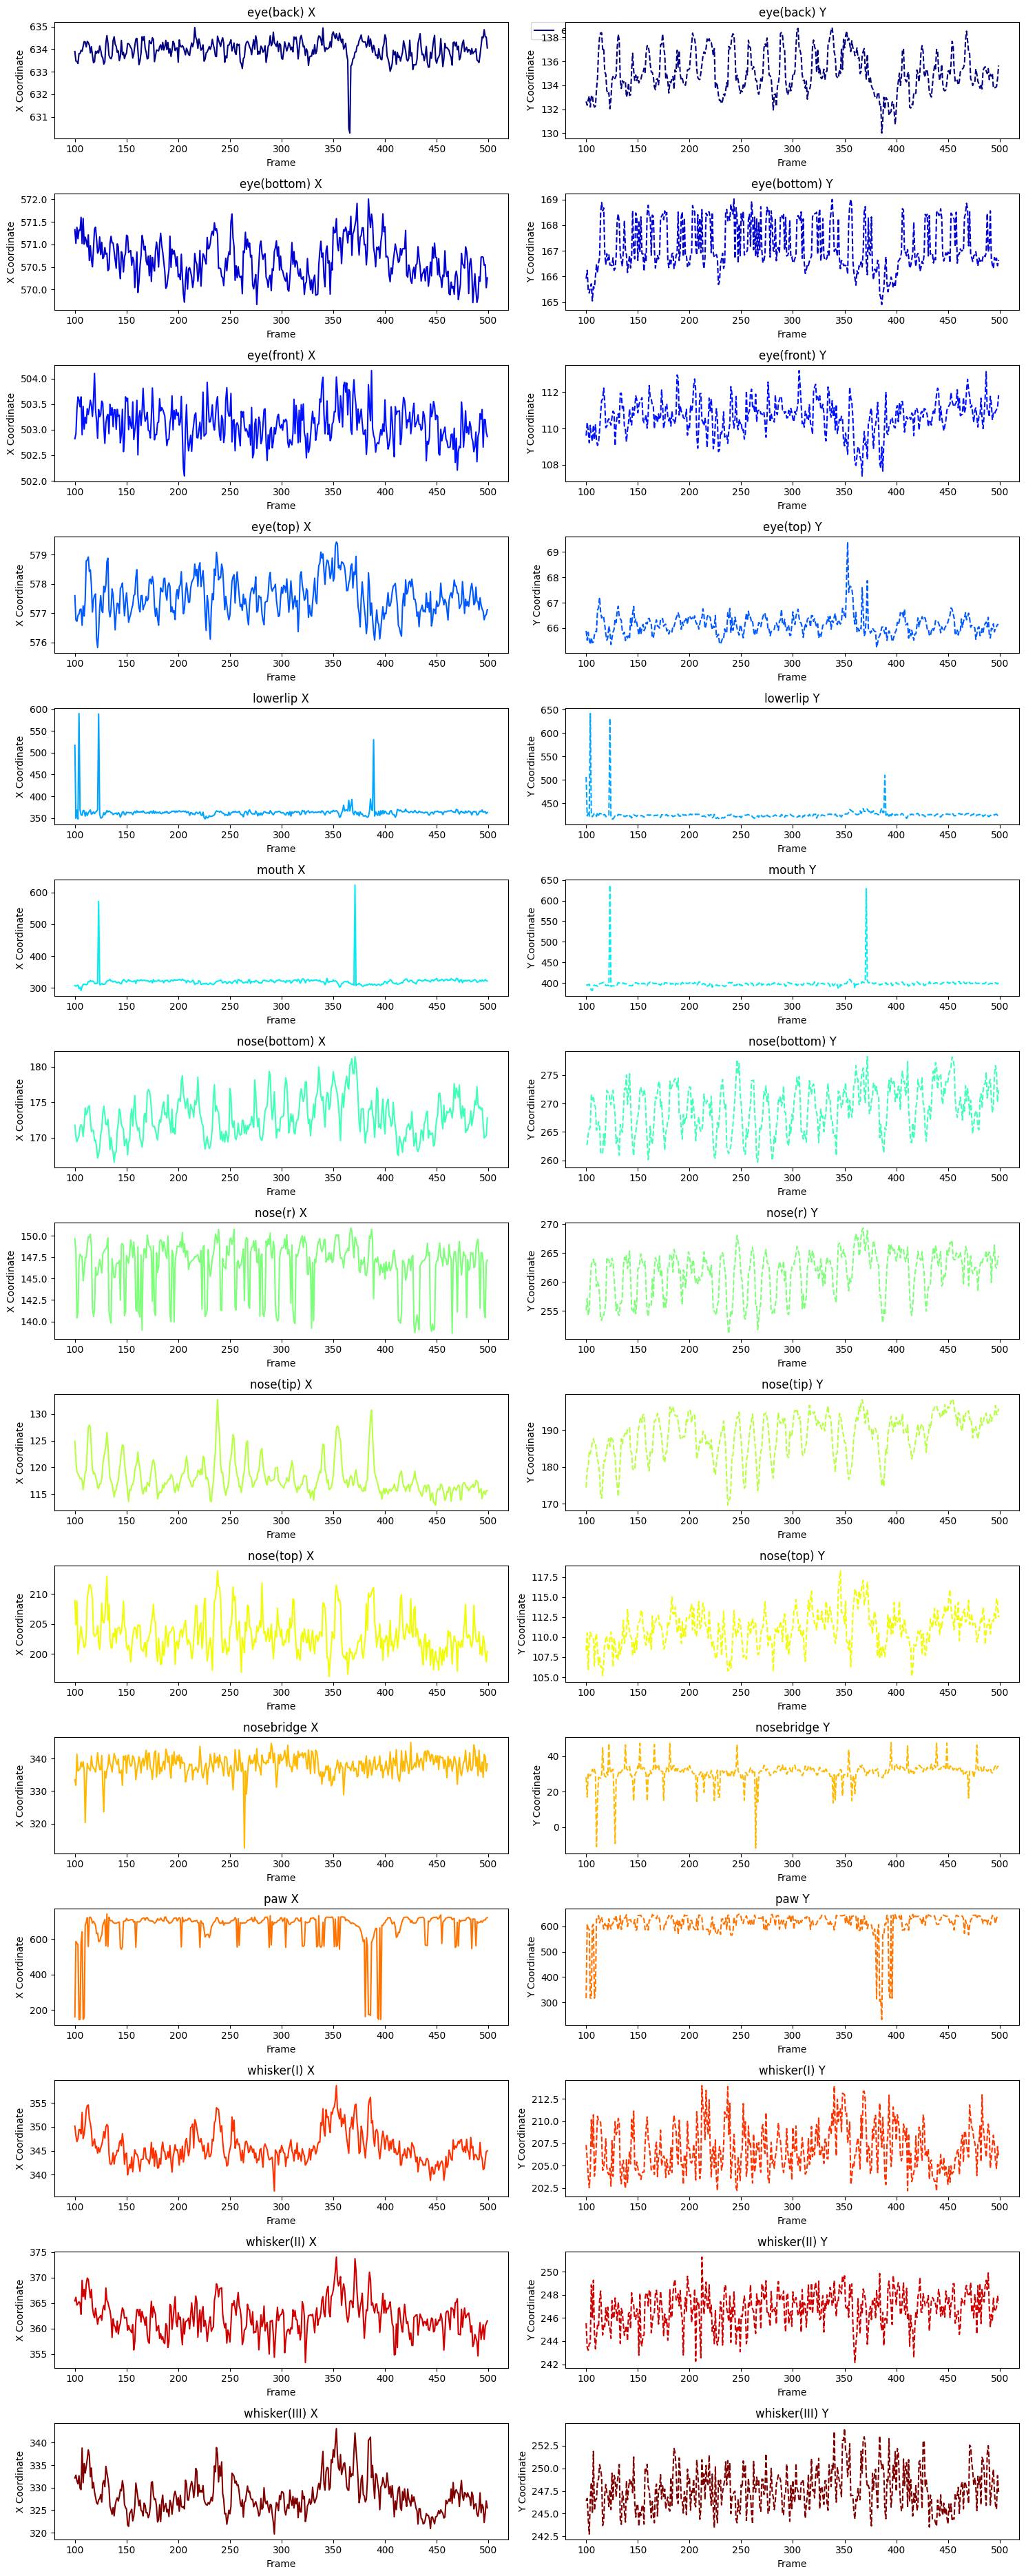

In [31]:
colors = cm.get_cmap("jet")(np.linspace(0, 1.0, len(body_parts)))
start_frame = 100
end_frame = 500

num_body_parts = len(body_parts)

fig, axs = plt.subplots(
    nrows=num_body_parts, ncols=2, figsize=(15, 2.5 * num_body_parts), dpi=100
)

for i, bodypart in enumerate(body_parts):
    # X Coordinate Plot
    axs[i, 0].plot(
        np.arange(start_frame, end_frame),
        pose_x_coord[i, start_frame:end_frame],
        "-",
        c=colors[i],
        label=f"{bodypart} X",
    )
    axs[i, 0].set_title(f"{bodypart} X")
    axs[i, 0].set_xlabel("Frame")
    axs[i, 0].set_ylabel("X Coordinate")

    # Y Coordinate Plot
    axs[i, 1].plot(
        np.arange(start_frame, end_frame),
        pose_y_coord[i, start_frame:end_frame],
        "--",
        c=colors[i],
        label=f"{bodypart} Y",
    )
    axs[i, 1].set_title(f"{bodypart} Y")
    axs[i, 1].set_xlabel("Frame")
    axs[i, 1].set_ylabel("Y Coordinate")

plt.tight_layout()
axs[0, 0].legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)

plt.show()